In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeat
import os
import sys
from glob import glob
from multiprocessing import Pool
import tempfile
import shutil
import imageio
from PIL import Image
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [2]:
from project.utils.geo_plots import plot_map, savefig
from project.utils.geo import msc_align, msc2date, stacktime

In [3]:
cube = xr.open_zarr('/Net/Groups/BGI/scratch/bkraft/drought_data/cube.zarr/')

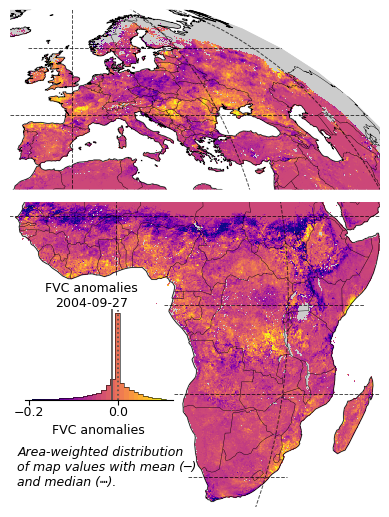

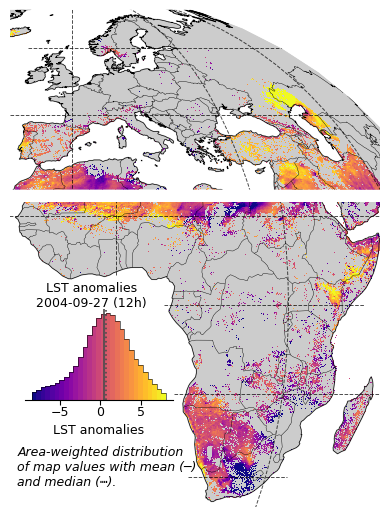

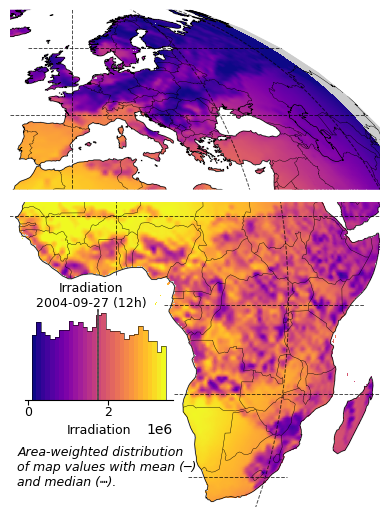

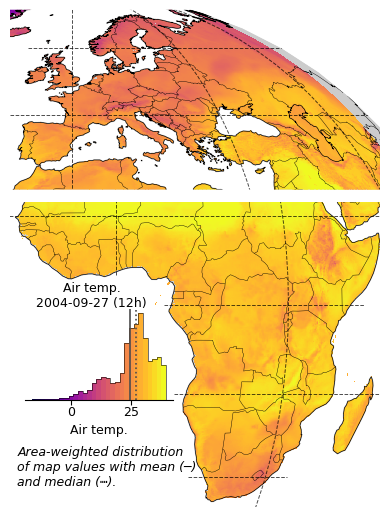

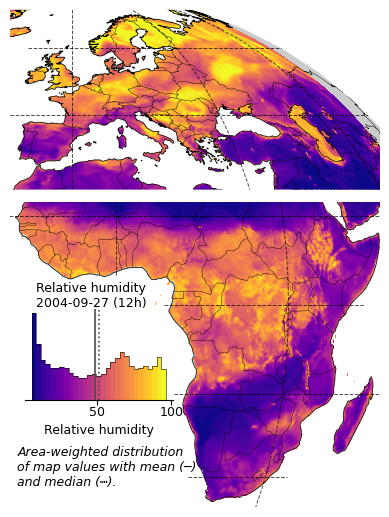

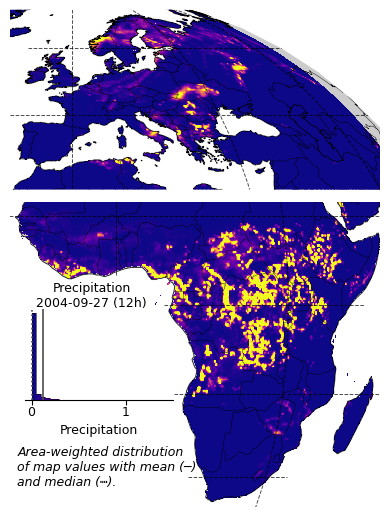

In [4]:
for key, name in {
    'fvc_ano': 'FVC anomalies',
    'lst_ano': 'LST anomalies',
    'ssrd': 'Irradiation',
    't2m': 'Air temp.',
    'rh_cf': 'Relative humidity',
    'tp': 'Precipitation'}.items():

    cube_sel = cube[key]

    if 'hour' in cube_sel.dims:
        cube_sel = cube_sel.isel(hour=12)
        hour = ' (12h)'
    else:
        hour = ''

    cube_sel = cube_sel.isel(time=(1000))

    date = cube_sel.time.dt.strftime('%Y-%m-%d').item()
    date += hour

    fig, _ = plot_map(
        cube_sel.load(),
        label=name,
        cmap='plasma',
        title=f'{name}\n{date}',
        robust=True,
        do_center=False
    );

    savefig(fig, path=f'../readme_imgs/{key}.png', dpi=150, transparent=True)

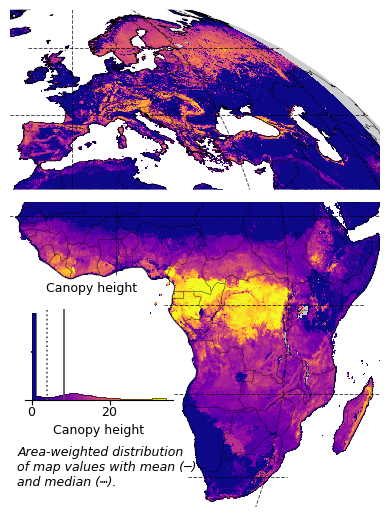

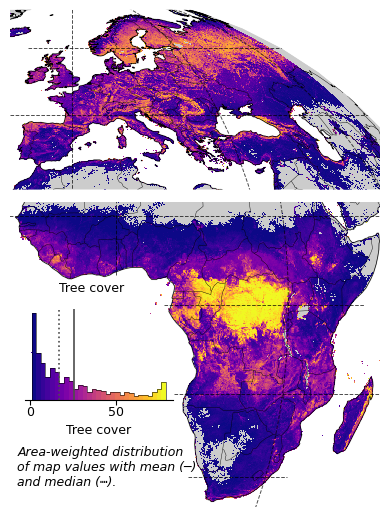

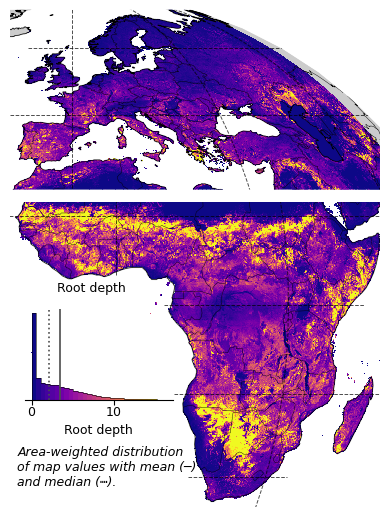

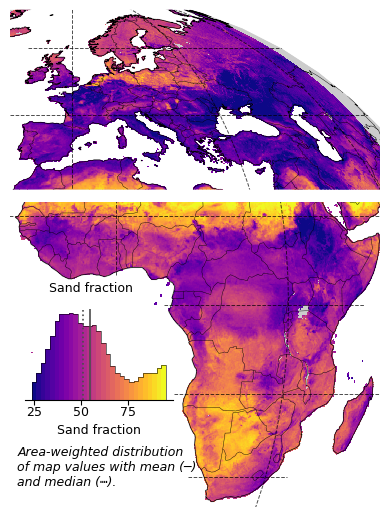

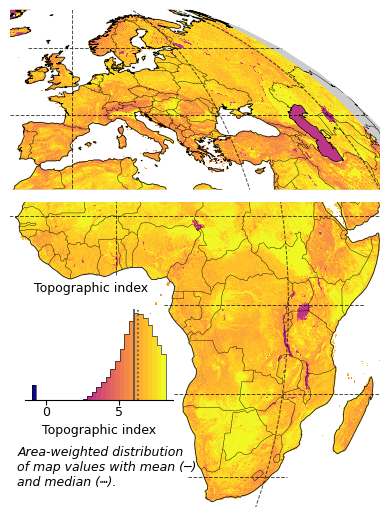

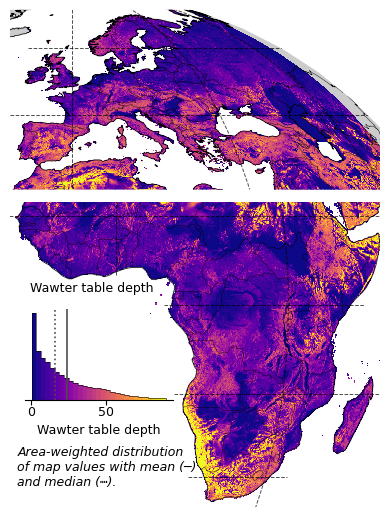

In [26]:
for key, name in {
        'canopyheight': 'Canopy height',
        'percent_tree_cover': 'Tree cover',
        'rootdepth': 'Root depth',
        'sandfrac': 'Sand fraction',
        'topidx': 'Topographic index',
        'wtd': 'Wawter table depth'}.items():

    fig, _ = plot_map(
        cube[key].load(),
        label=name,
        cmap='plasma',
        title=name,
        robust=True,
        do_center=False
    );

    savefig(fig, path=f'../readme_imgs/{key}.png', dpi=150, transparent=True)

In [5]:
cube_ss = cube.sel(lat=-30, lon=20)

(0.0, 1000.0)

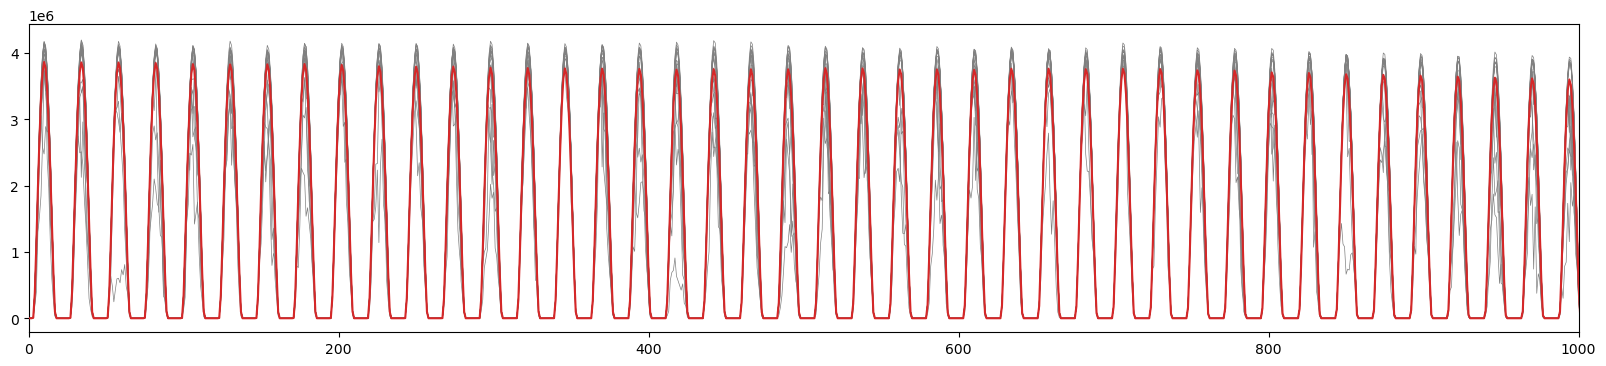

In [8]:
fig, ax = plt.subplots(figsize=(20, 4))
var = 'ssrd'

ax.plot(msc2date(cube_ss[var + '_msc']), lw=1.5, color='tab:red', zorder=1000)

for year in range(2002, 2022):
    ax.plot(stacktime(cube_ss[var].sel(time=str(year))), color='0.5', lw=0.5)

ax.set_xlim(0, 1000)

In [10]:
def make_figure(ncols=1, center=(0, 0)):
    fig, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(5 * ncols, 5), subplot_kw={'projection': ccrs.Orthographic(*center)}, squeeze=False, gridspec_kw={'wspace': 0})

    for ax in axes.flat:
        # generate a basemap with country borders, oceans and coastlines
        ax.add_feature(cfeat.LAND, color='0.6')
        ax.add_feature(cfeat.OCEAN, color='0.4')
        ax.add_feature(cfeat.COASTLINE, lw=.7)
        ax.add_feature(cfeat.BORDERS, linestyle='dotted', lw=0.5)
        ax.set_global()
        #ax.set_extent([-100, 30, 0, 80], crs=ccrs.PlateCarree())
    return fig, axes[0, :]

def make_figure_flat(ncols=1):
    fig, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(6 * ncols, 6), subplot_kw={'projection': ccrs.Mollweide()}, gridspec_kw={'wspace': 0}, squeeze=False)

    for ax in axes.flat:
        # generate a basemap with country borders, oceans and coastlines
        ax.add_feature(cfeat.LAND, color='0.6')
        #ax.add_feature(cfeat.OCEAN, color='0.4')
        ax.add_feature(cfeat.COASTLINE, lw=.7)
        ax.add_feature(cfeat.BORDERS, linestyle='dotted', lw=0.3)
        ax.set_global()
        ax.set_extent([-120, 150, -58, 90], crs=ccrs.PlateCarree())
        ax.spines['geo'].set_visible(False)
        ax.patch.set_visible(False)
    return fig, axes[0, :]

def plot_t(ds_t, vmin, vmax, title, save_dir=None, dpi=200, cmap='BrBG', levels=None, rotate=0, globe=True, t=False, is_hourly=True, **kwargs):

    if isinstance(ds_t, xr.DataArray):
        if not isinstance(vmin, (int, float, str)):
            raise TypeError('`vmin` must be numeric or a string.')
        if not isinstance(vmax, (int, float, str)):
            raise TypeError('`vmax` must be numeric or a string.')
        if not isinstance(title, str):
            raise TypeError('`title` must be a string.')
        if not isinstance(title, str):
            raise TypeError('`cmap` must be a string.')
        ds_t = [ds_t]
        vmin = [vmin]
        vmax = [vmax]
        title = [title]
        cmap = [cmap]
    else:
        if not isinstance(vmin, list):
            raise TypeError('`vmin` must be a list as multiple datasets were passed.')
        if not isinstance(vmax, list):
            raise TypeError('`vmax` must be a list as multiple datasets were passed.')
        if not isinstance(title, list):
            raise TypeError('`title` must be a list as multiple datasets were passed.')
        if not isinstance(cmap, list):
            raise TypeError('`cmap` must be a list as multiple datasets were passed.')

    extends = []
    vmins = []
    vmaxs = []

    for mn, mx in zip(vmin, vmax):
        if isinstance(mn, str):
            if isinstance(mx, str):
                extends.append('both')
            else:
                extends.append('min')
        else:
            if isinstance(mx, str):
                extends.append('max')
            else:
                extends.append('neither')
            
        vmins.append(float(mn))
        vmaxs.append(float(mx))


    num_ds = len(ds_t)

    if globe:
        fig, axes = make_figure(num_ds, center=(rotate % 360, 0))
    else:
        fig, axes = make_figure_flat(num_ds)

    for i, ax in enumerate(axes):

        if levels is None:
            img = ds_t[i].plot.imshow(
                ax=ax,
                transform=ccrs.PlateCarree(),
                add_colorbar=True,
                vmin=vmins[i],
                vmax=vmaxs[i],
                cmap=cmap[i],
                cbar_kwargs=dict(
                    orientation='horizontal', pad=0.0, shrink=0.5, label='', aspect=60, extend=extends[i]
                ),
                **kwargs
            )
        else:
            img = ds_t[i].plot.contourf(
                levels=levels,
                ax=ax,
                transform=ccrs.PlateCarree(),
                add_colorbar=True,
                vmin=vmins[i],
                vmax=vmaxs[i],
                cmap=cmap,
                cbar_kwargs=dict(
                    orientation='horizontal', pad=0.0, shrink=0.5, label='', aspect=60, extend=extends[i]
                ),
                **kwargs
            )

        if is_hourly:
            time = ds_t[i].time.dt.strftime("%Y-%m-%d-%H").item()
        else:
            time = ds_t[i].time.dt.strftime("%Y-%m-%d").item()

        if globe:
            cbax = inset_axes(ax,
                        width="100%",  # width = 50% of parent_bbox width
                        height="100%",  # height : 5%
                        loc='lower center',
                        bbox_to_anchor=(0.28, 0.12, 0.45, 0.02) if globe else (0.32, 0.0, 0.5, 0.02),
                        bbox_transform=ax.transAxes)
            img.colorbar.remove()         
            cbar = fig.colorbar(img, cax=cbax, orientation='horizontal', extend=extends[i])
            cbar.ax.set_title(f'{title[i]} – {time}', size=11)
            cbar.ax.tick_params(labelsize=11)
        else:
            img.colorbar.ax.set_title(f'{title[i]} – {time}', size=11, pad=0)
            img.colorbar.ax.tick_params(labelsize=11)

        #cbar.ax.xaxis.set_tick_params(color='w')
        #cbar.outline.set_edgecolor('w')
        #plt.setp(plt.getp(cbar.ax.axes, 'xticklabels'), color='w')

        ax.set_title('')
        #ax.text(0.3, 0.3, f'{title} – {time}', transform=ax.transAxes, color='w')

    # fig.tight_layout()

    if save_dir is None:
        return img
    else:
        if i is None:
            path = os.path.join(save_dir, f'frame_{time}.png')
        else:
            path = os.path.join(save_dir, f'frame_{t:05d}.png')

        fig.savefig(path, dpi=dpi, bbox_inches='tight', transparent=True)
        plt.close(fig)
        del ds_t, img, ax, title

def animate(
        ds, vmin, vmax, title, save_path, timerange=-1, levels=None,
        globe=True, rotate_speed=0, dpi=150, cmap='BrBG', fps=15, ncpus=1, use_pil=False,
        png_out=False):

    tmpdir = tempfile.mkdtemp(dir=os.path.dirname(save_path))

    if isinstance(ds, xr.Dataset):
        raise TypeError('must pass an xr.DataArray, not an xr.Dataset.')
    elif isinstance(ds, xr.DataArray):
        if not isinstance(vmin, (int, float, str)):
            raise TypeError('`vmin` must be numeric or a string.')
        if not isinstance(vmax, (int, float, str)):
            raise TypeError('`vmax` must be numeric or a string.')
        if not isinstance(title, str):
            raise TypeError('`title` must be a string.')
        if not isinstance(cmap, str):
            raise TypeError('`cmap` must be a string.')

        ntime = len(ds.time)

    else:
        if not isinstance(vmin, list):
            raise TypeError('`vmin` must be a list as multiple datasets were passed.')
        if not isinstance(vmax, list):
            raise TypeError('`vmax` must be a list as multiple datasets were passed.')
        if not isinstance(title, list):
            raise TypeError('`title` must be a list as multiple datasets were passed.')
        if not isinstance(cmap, list):
            raise TypeError('`cmap` must be a list as multiple datasets were passed.')

        ntime = len(ds[0].time)

    if timerange == -1:
        timerange = range(ntime)
    elif isinstance(timerange, int):
        timerange = range(timerange)

    if isinstance(ds, list):
        timedim = ds[0]['time']
    else:
        timedim = ds['time']

    is_hourly = xr.infer_freq(timedim) == 'H'

    try:

        par_kwargs = [{
            'ds_t': ds.isel(time=t) if isinstance(ds, xr.DataArray) else [ds[i].isel(time=t) for i in range(len(ds))],
            'vmin': vmin,
            'vmax': vmax,
            'title': title,
            'save_dir': tmpdir,
            'dpi': dpi,
            'cmap': cmap,
            'levels': levels,
            'rotate': t * rotate_speed,
            'globe': globe,
            't': t,
            'is_hourly': is_hourly
        } for t in timerange]

        par_args = [list(el.values()) for el in par_kwargs]

        # parcall(plot_t, ds_args, dry_run=False, num_cpus=ncpus, vmin=vmin, vmax=vmax, levels=levels,
        #     globe=globe, save_dir=tmpdir, title=title, cmap=cmap, dpi=dpi);

        with Pool(processes=min(len(par_args), ncpus)) as pool:
            pool.starmap(plot_t, par_args)

        fp_in = os.path.join(tmpdir, 'frame*.png')
        paths = sorted(glob(fp_in))

        if not png_out:
            #command = f'convert -delay {100 / fps} -loop 0 {fp_in} {save_path}'
            command = f'ffmpeg -y -threads 16 -framerate {fps} -pattern_type glob -i \'{fp_in}\' -b:v 0  -crf 40 -c:v libvpx-vp9 -pix_fmt yuva420p {save_path}/{title}.webm'
            print(command)
            os.system(command)
            print('Done.')

        else:
            if os.path.isdir(save_path):
                shutil.rmtree(save_path)
            os.rename(tmpdir, save_path)

    finally:
        shutil.rmtree(tmpdir, ignore_errors=True)

        


In [11]:
ds = xr.open_zarr('/Net/Groups/BGI/scratch/bkraft/drought_data/cube.zarr/')
ds

<xarray.Dataset>
Dimensions:  (time: 7305, lat: 1140, lon: 1460, hour: 24)
Coordinates:
  * hour     (hour) int64 0 1 2 3 4 5 6 7 8 9 ... 14 15 16 17 18 19 20 21 22 23
  * lat      (lat) float32 76.5 76.4 76.3 76.2 76.1 ... -37.1 -37.2 -37.3 -37.4
  * lon      (lon) float32 -74.5 -74.4 -74.3 -74.2 -74.1 ... 71.1 71.2 71.3 71.4
  * time     (time) datetime64[ns] 2002-01-01 2002-01-02 ... 2021-12-31
Data variables:
    fvc      (time, lat, lon) float32 dask.array<chunksize=(100, 10, 10), meta=np.ndarray>
    lst      (hour, time, lat, lon) float32 dask.array<chunksize=(24, 100, 10, 10), meta=np.ndarray>
    rh_cf    (hour, time, lat, lon) float32 dask.array<chunksize=(24, 100, 10, 10), meta=np.ndarray>
    ssrd     (hour, time, lat, lon) float32 dask.array<chunksize=(24, 100, 10, 10), meta=np.ndarray>
    t2m      (hour, time, lat, lon) float32 dask.array<chunksize=(24, 100, 10, 10), meta=np.ndarray>
    tp       (hour, time, lat, lon) float32 dask.array<chunksize=(24, 100, 10, 10), meta=np.ndarray>

In [13]:
animate(ds.fvc.sel(time='2005').load(), vmin=0, vmax=1, title='FVC', save_path='../visualization/anim/', timerange=365, ncpus=40, png_out=False)

ffmpeg -y -threads 16 -framerate 15 -pattern_type glob -i '../visualization/anim/tmpzcpvujqu/frame*.png' -b:v 0  -crf 40 -c:v libvpx-vp9 -pix_fmt yuva420p ../visualization/anim//FVC.webm


ffmpeg version 5.1.2 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 10.4.0 (conda-forge gcc 10.4.0-16)
  configuration: --prefix=/home/conda/feedstock_root/build_artifacts/ffmpeg_1664280367634/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_plac --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1664280367634/_build_env/bin/x86_64-conda-linux-gnu-cc --cxx=/home/conda/feedstock_root/build_artifacts/ffmpeg_1664280367634/_build_env/bin/x86_64-conda-linux-gnu-c++ --nm=/home/conda/feedstock_root/build_artifacts/ffmpeg_1664280367634/_build_env/bin/x86_64-conda-linux-gnu-nm --ar=/home/conda/feedstock_root/build_artifacts/ffmpeg_1664280367634/_build_env/bin/x86_64-conda-linux-gnu-ar --disable-doc --disable-openssl --enable-demuxer=dash --enable-hardcoded-tables --enable-libfreetype --enable-libfontconfig --enable-libopenh264 --enable-gnu

Done.


frame=  365 fps=2.4 q=35.0 Lsize=    1008kB time=00:00:24.26 bitrate= 340.2kbits/s speed=0.16x    
video:977kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 3.216996%


In [18]:
ds_miss = ds.fvc.sel(time=slice('2003', '2006')).isnull().all(('lat', 'lon')).compute()

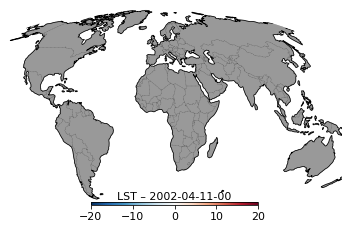

In [8]:
plot_t(ds.lst.isel(time=100, hour=7), vmin=-20, vmax=20, title='LST', cmap='RdBu_r', globe=True)

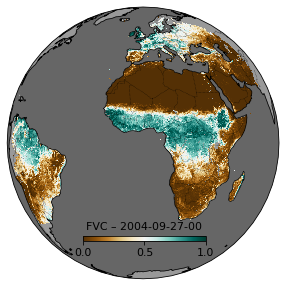

In [11]:
plot_t(ds.fvc.isel(time=700), 0, 1, 'FVC', globe=True)

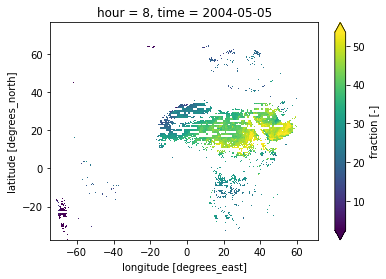

In [20]:
ds.lst.sel(time='2004-05-05', hour=8).plot(robust=True)

In [43]:
ds_ = xr.open_dataset('/Net/Groups/BGI/scratch/bkraft/drought_data/preproc/tp.hourly.1460.1140.05.2004.nc').rename({'latitude': 'lat', 'longitude': 'lon'})
ds_

<xarray.Dataset>
Dimensions:  (time: 744, lon: 1460, lat: 1140)
Coordinates:
  * time     (time) datetime64[ns] 2004-05-01 ... 2004-05-31T23:00:00
  * lon      (lon) float32 -74.5 -74.4 -74.3 -74.2 -74.1 ... 71.1 71.2 71.3 71.4
  * lat      (lat) float32 76.5 76.4 76.3 76.2 76.1 ... -37.1 -37.2 -37.3 -37.4
Data variables:
    tp       (time, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 2.0.5 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Thu Oct 13 09:52:04 2022: cdo -O -s remap,preprocessing/gri...
    CDO:          Climate Data Operators version 2.0.5 (https://mpimet.mpg.de...
    min_val:      0.0
    max_val:      0.4185318648815155

In [44]:
ds_s = ds.tp.sel(time='2004-05-05T', hour=8)

In [45]:
ds__s = ds_.tp.sel(time='2004-05-05T08')

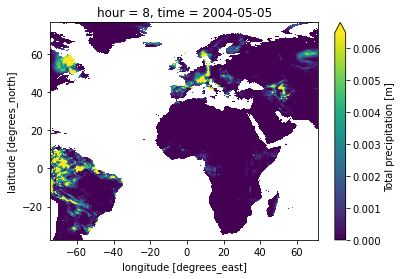

In [50]:
ds_s.plot(robust=True)

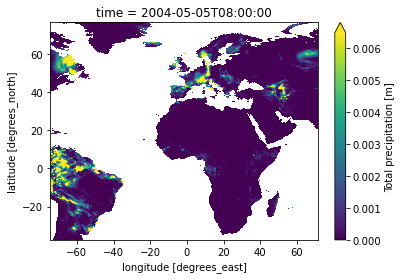

In [51]:
ds__s.plot(robust=True)

In [48]:
dff = (ds_s - ds__s).compute()

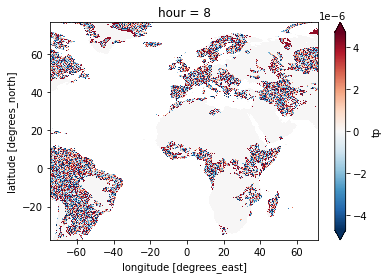

In [49]:
dff.plot(robust=True)

In [87]:
import numpy as np
import pandas as pd

In [94]:
ds = xr.DataArray(np.random.uniform(size=72).reshape(3, 24), dims=['time', 'hour'], coords=[pd.date_range('2002-01-01', '2002-01-03', freq='D'), np.arange(24)])

<xarray.DataArray (time: 3, hour: 24)>
array([[ 0.62721032,  1.08378932,  1.28687708,  1.77822307,  1.84344947,
         2.33537519,  3.21212493,  3.71996351,  4.2186126 ,  4.90113025,
         5.00994247,  5.64480515,  6.27316883,  6.40371899,  7.4028848 ,
         8.26716601,  8.30039793,  8.98778367,  9.1505924 ,  9.31365747,
        10.0784238 , 10.7095515 , 10.90324456, 11.80856241],
       [ 0.44716285,  0.68966895,  1.6061826 ,  2.30649686,  2.91144702,
         3.82405571,  4.58884259,  5.24391232,  5.27209205,  6.25420306,
         6.68391556,  7.36207401,  7.72972322,  8.65041265,  9.58339671,
        10.0864937 , 10.29660202, 10.33949915, 11.14830647, 11.40345438,
        12.19954755, 12.84037349, 12.84345597, 13.10391172],
       [ 0.01755992,  0.62743801,  1.04957012,  1.5920923 ,  1.81617743,
         2.57421213,  3.00273695,  3.4284279 ,  3.5751241 ,  4.46963652,
         5.12451301,  5.16099016,  5.38041514,  6.18211908,  7.01540942,
         7.04176191,  7.22704467,  7.92991717,  8.52841155,  9.33348894,
        10.29735482, 10.57330558, 10.62831282, 10.88038876]])
Coordinates:
  * time     (time) datetime64[ns] 2002-01-01 2002-01-02 2002-01-03
  * hour     (hour) int64 0 1 2 3 4 5 6 7 8 9 ... 14 15 16 17 18 19 20 21 22 23

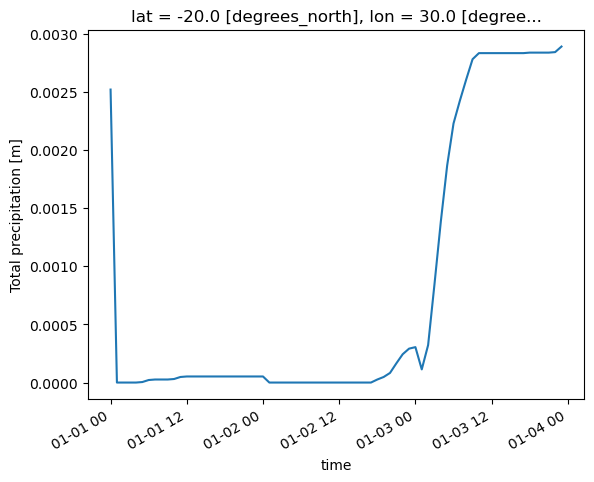

In [100]:
stacktime(cube_ss.tp).sel(time=slice('2002-01-01', '2002-01-03')).plot()

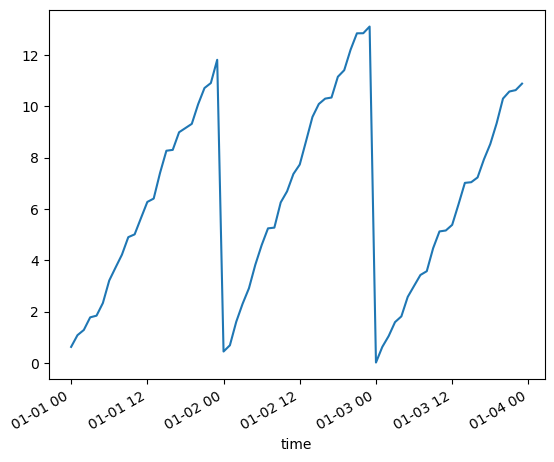

In [97]:
stacktime(ds.cumsum('hour')).plot()

In [214]:
xr.open_dataset('/Net/Groups/BGI/data/DataStructureMDI/DATA/grid/SEVIRI/0d10_daily/MDLST/Data/LST.1460.1140.01.2004.nc').isel(time=slice(0, 25)).time

<xarray.DataArray 'time' (time: 25)>
array(['2004-01-01T00:00:00.000040000', '2004-01-01T01:00:00.000027000',
       '2004-01-01T02:00:00.000054000', '2004-01-01T03:00:00.000040000',
       '2004-01-01T04:00:00.000027000', '2004-01-01T05:00:00.000054000',
       '2004-01-01T06:00:00.000040000', '2004-01-01T07:00:00.000027000',
       '2004-01-01T08:00:00.000054000', '2004-01-01T09:00:00.000040000',
       '2004-01-01T10:00:00.000027000', '2004-01-01T11:00:00.000054000',
       '2004-01-01T12:00:00.000040000', '2004-01-01T13:00:00.000027000',
       '2004-01-01T14:00:00.000054000', '2004-01-01T15:00:00.000040000',
       '2004-01-01T16:00:00.000027000', '2004-01-01T17:00:00.000054000',
       '2004-01-01T18:00:00.000040000', '2004-01-01T19:00:00.000027000',
       '2004-01-01T20:00:00.000054000', '2004-01-01T21:00:00.000040000',
       '2004-01-01T22:00:00.000027000', '2004-01-01T23:00:00.000054000',
       '2004-01-02T00:00:00.000040000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2004-01-01T00:00:00.000040 ... 2004-01-02T...
Attributes:
    long_name:  time

In [217]:
xr.open_dataset('/Net/Groups/data_BGC/era5_land/e1/0d10_hourly/')

<xarray.Dataset>
Dimensions:    (time: 720, longitude: 3600, latitude: 1801)
Coordinates:
  * time       (time) datetime64[ns] 2002-06-01 ... 2002-06-30T23:00:00
  * longitude  (longitude) float32 0.0 0.1 0.2 0.3 ... 359.6 359.7 359.8 359.9
  * latitude   (latitude) float32 90.0 89.9 89.8 89.7 ... -89.8 -89.9 -90.0
Data variables:
    rH_cf      (time, latitude, longitude) float32 ...
Attributes:
    title:         era5_land calculated rH_cf
    version:       e1
    history:       created: Fri Aug 12 17:24:13 2022
    provided_by:   ear5_land
    created_by:    uweber@bgc-jena.mpg.de
    method_rH_cf:  RH = e/es*100.

In [224]:
d = xr.open_dataset('/Net/Groups/BGI/scratch/bkraft/drought_data/preproc/')
d

<xarray.Dataset>
Dimensions:    (time: 744, longitude: 1460, latitude: 1140)
Coordinates:
  * time       (time) datetime64[ns] 2002-01-01 ... 2002-01-31T23:00:00
  * longitude  (longitude) float32 -74.5 -74.4 -74.3 -74.2 ... 71.2 71.3 71.4
  * latitude   (latitude) float32 76.5 76.4 76.3 76.2 ... -37.2 -37.3 -37.4
Data variables:
    tp         (time, latitude, longitude) float32 ...
Attributes:
    CDI:          Climate Data Interface version 2.0.5 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Tue Oct 18 13:43:55 2022: cdo -O -s remap,preprocessing/gri...
    CDO:          Climate Data Operators version 2.0.5 (https://mpimet.mpg.de...
    min_val:      0.0
    max_val:      0.2855195999145508

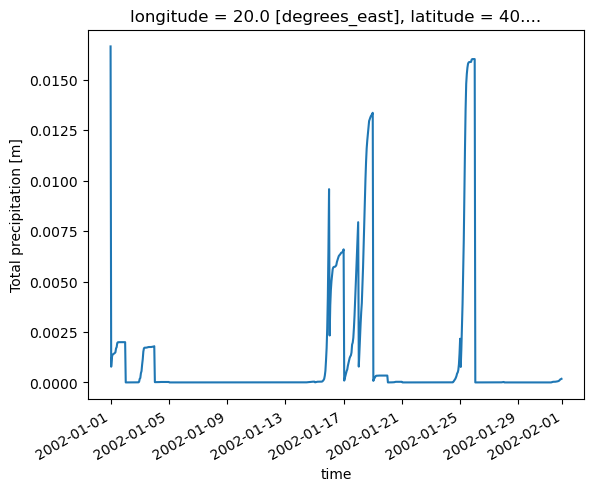

In [223]:
d.plot()

In [117]:
import dask

def c2flux(
    path: str,
    var: str,
    lat_subset: slice,
    lon_subset: slice):

    da = cube[var].isel(lat=lat_subset, lon=lon_subset).load()
    da_flat = da.values.reshape(-1, *da.shape[-2:])
    da_flat_diff = np.diff(da_flat, axis=0, append=0)
    da_flat_diff[0::24] = da_flat[1::24]
    da_flat_diff[-1, ...] = 0.0
    da.values = da_flat_diff.reshape(-1, 24, *da.shape[-2:])

    da = da.drop_vars(['hour', 'time'])
    ds = xr.Dataset()
    ds[var] = da

    with dask.config.set(**{'array.slicing.split_large_chunks': False}):
        ds.to_zarr(path, consolidated=True, region={
            'lat': lat_subset,
            'lon': lon_subset
        })


In [137]:
r = c2flux('/Net/Groups/BGI/scratch/bkraft/drought_data/cube.zarr/', 'ssrd', slice(860, 880), slice(1040, 1060))

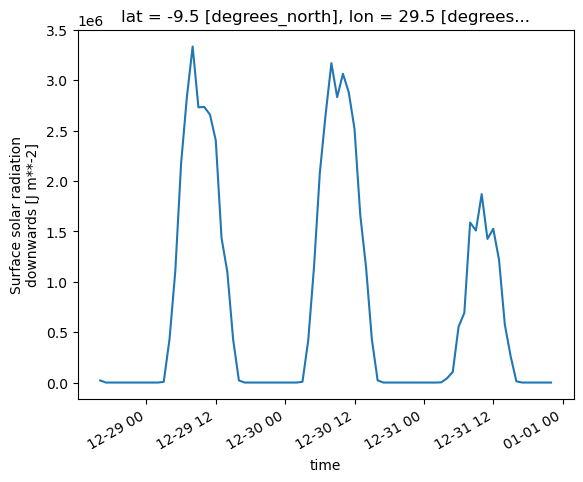

In [139]:
stacktime(cube.ssrd.isel(lat=slice(860, 880), lon=slice(1040, 1060)).isel(lat=0, lon=0)).isel(time=slice(-80, -1)).plot()

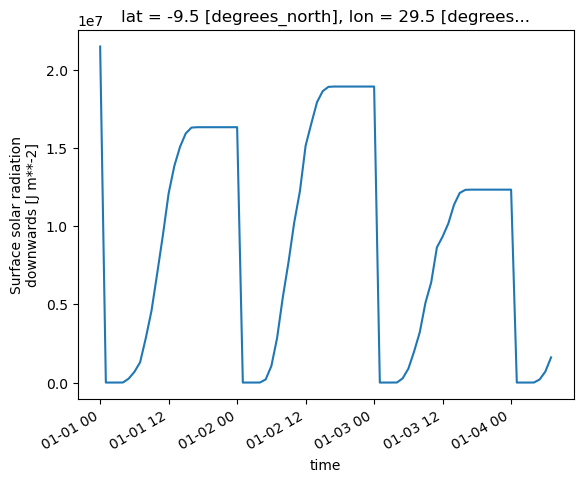

In [136]:
stacktime(cube.ssrd.isel(lat=slice(860, 880), lon=slice(1040, 1060)).isel(lat=0, lon=0)).isel(time=slice(0, 80)).plot()

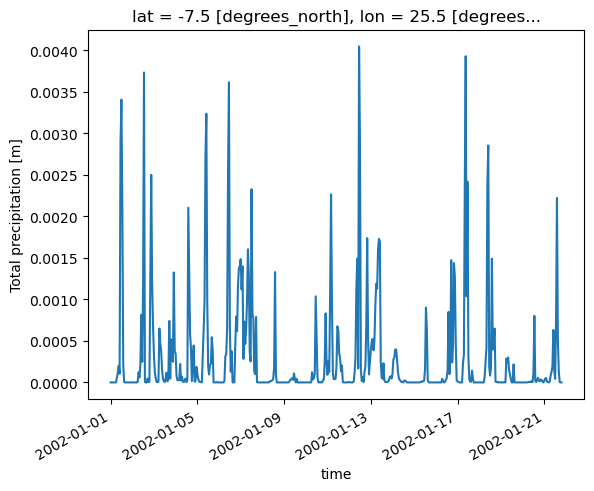

In [104]:
stacktime(r).isel(time=slice(0, 500)).isel(lat=0, lon=0).plot()

(array([7.0002059e+07, 9.5635000e+04, 1.7733000e+04, 6.0990000e+03,
        3.0490000e+03, 1.9070000e+03, 8.5800000e+02, 4.6600000e+02,
        1.4600000e+02, 4.8000000e+01]),
 array([-2.98023224e-08,  3.45235206e-02,  6.90470710e-02,  1.03570618e-01,
         1.38094172e-01,  1.72617719e-01,  2.07141265e-01,  2.41664812e-01,
         2.76188374e-01,  3.10711920e-01,  3.45235467e-01]),
 <BarContainer object of 10 artists>)

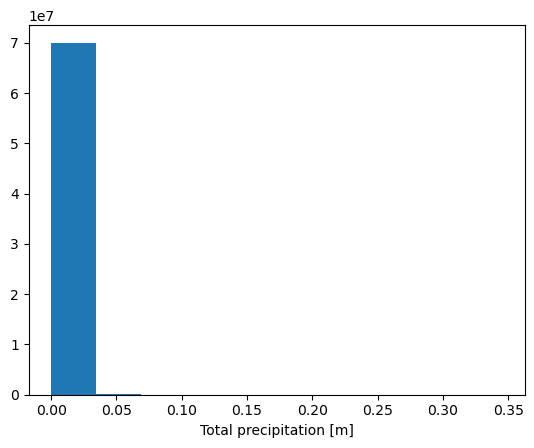

In [65]:
cube_ss = cube.isel(lat=slice(840, 860), lon=slice(1000, 1020))[['tp', 'ssrd']].load()
cube_new = cube_ss.copy()
cube_ss.tp.plot()

In [81]:
cube_flat = cube_ss.ssrd.values.reshape(-1, 20, 20)
cube_flat_diff = np.diff(cube_flat, axis=0, append=0)
cube_flat_diff.shape

(175320, 20, 20)

In [82]:
cube_flat_diff[0::24] = cube_flat[1::24]
cube_flat_diff[-1, ...] = 0.0

In [83]:
cube_flat_diff.reshape(-1, 24, 20, 20).shape

(7305, 24, 20, 20)

In [84]:
cube_new['tp'].values = cube_flat_diff.reshape(-1, 24, 20, 20)

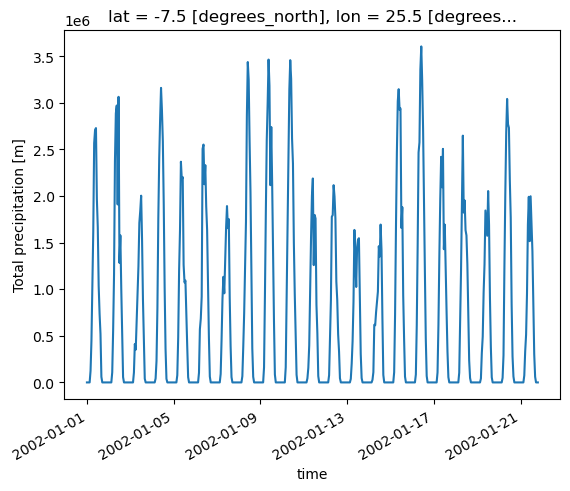

In [88]:
stacktime(cube_new.tp.isel(lat=0, lon=0)).isel(time=slice(0, 500)).plot()

In [64]:
stacktime(cube_flat_diff).isel(lat=0, lon=0).plot()

AttributeError: 'numpy.ndarray' object has no attribute 'dims'

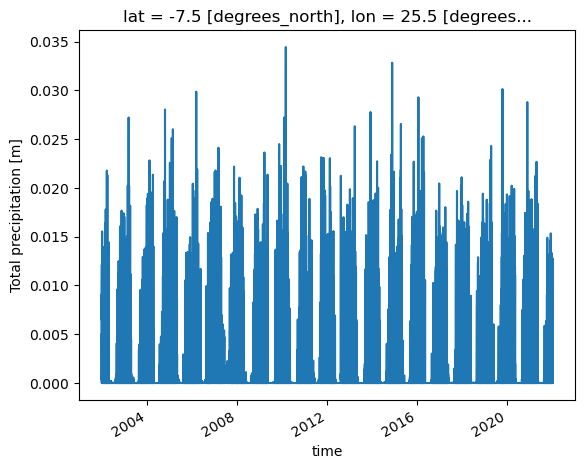

In [56]:
stacktime(cube_ss.tp).isel(lat=0, lon=0).plot()

In [341]:
cube_flat = cube_ss.values.reshape(-1, 11)[:200, :]
cube_flat.shape

(200, 11)

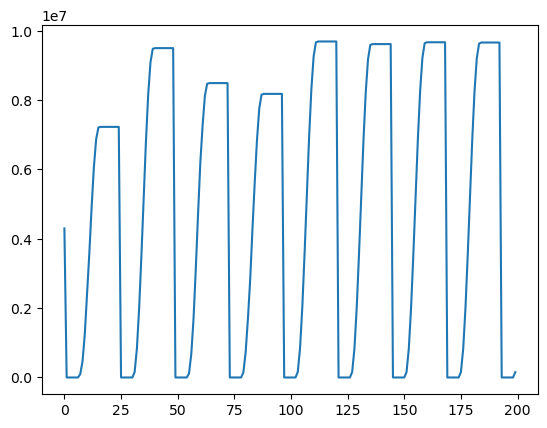

In [342]:
plt.plot(cube_flat[:, 0])

In [343]:
cube_flat[:, 0].shape

(200,)

In [344]:
cube_flat_diff = np.diff(cube_flat[:, 0], append=0)
cube_flat_diff.shape

(200,)

In [345]:
cube_flat_diff_ = cube_flat_diff.copy()
cube_flat_diff[0::24] = cube_flat[1::24, 0]

(-0.0005, 2276271.4)

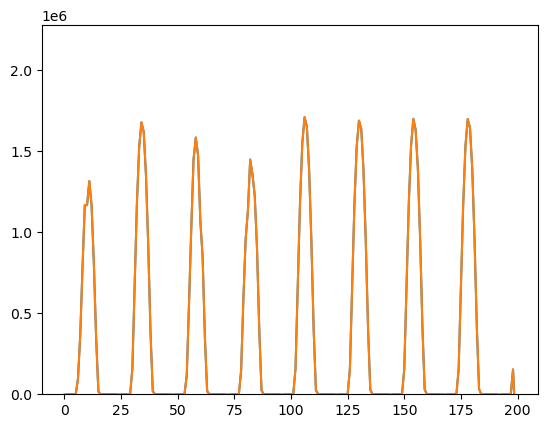

In [347]:
#plt.plot(cube_flat[:, 0])
plt.plot(cube_flat_diff_)
plt.plot(cube_flat_diff)
plt.ylim(-0.0005, None)

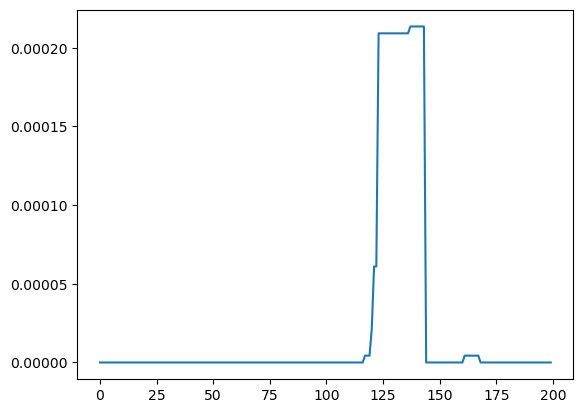

In [273]:
plt.plot(cube_ss.tp.values.reshape(-1, 11)[1:, 0][:200])

In [276]:
cube_ss.tp.values.shape

(7305, 24, 11)

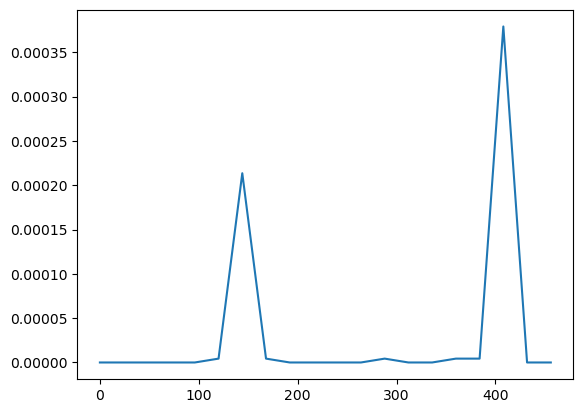

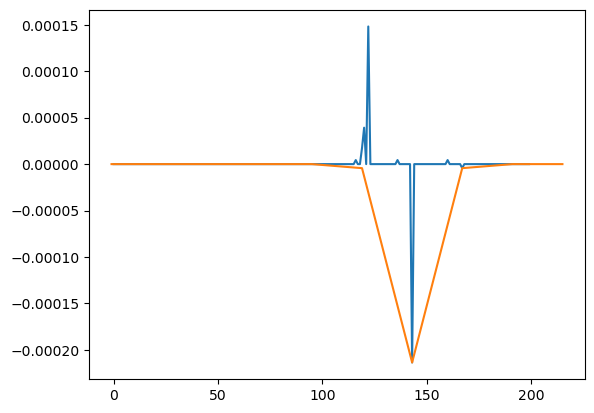

In [288]:
plt.plot(np.diff(cube_ss.tp.values.reshape(-1, 11)[1:, 0], axis=0)[:200])
plt.plot(np.arange(10) * 24 - 1, -cube_ss.tp.values[:, 0, 0][:10])

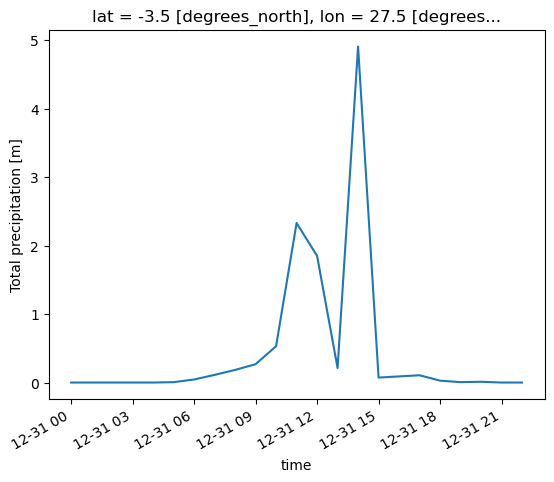

In [21]:
stacktime(cube.tp.isel(lat=800, lon=1020)).sel(time='2006-12-31').plot()

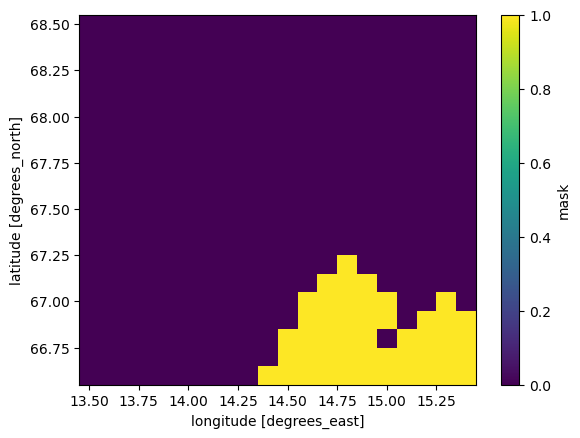

In [44]:
mask.isel(lat=chunks[0][2], lon=chunks[0][3]).plot()

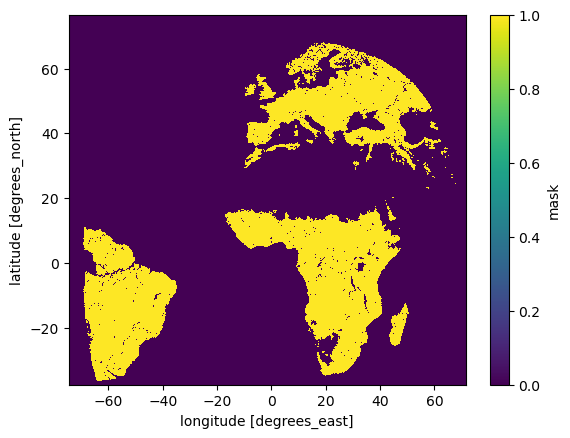

In [26]:
mask.plot()

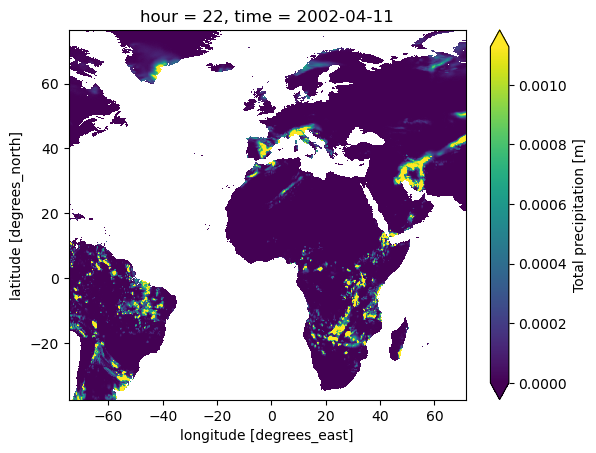

In [151]:
cube.tp.isel(time=100, hour=-2).plot(robust=True)

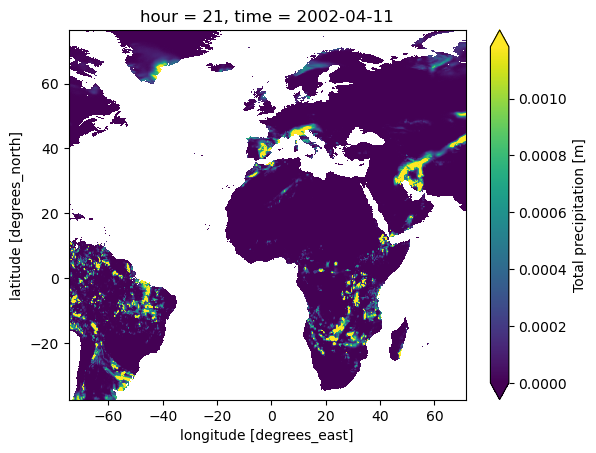

In [152]:
cube.tp.isel(time=100, hour=-3).plot(robust=True)

In [29]:
from tqdm import tqdm
from time import sleep

N = 100000

# miniters and maxinterval=float("inf")
for i in tqdm(range(N), total=N, miniters=0.1, maxinterval=float("inf")):
    sleep(0.01)


  1%|█▌                                                                                                                                                                   | 949/100000 [00:09<16:49, 98.16it/s]


KeyboardInterrupt: 